In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import xarray as xr

from global_land_mask import globe

In [2]:
def lon360to180_xr(ds,lonname='lon'):
	# Based on https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
	ds.coords[lonname] = (ds.coords[lonname] + 180) % 360 - 180
	ds = ds.sortby(ds[lonname])
	return ds

def detrend(da, dim='time', deg=1):
    # detrend the dataset da along the time dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

Compute the AMV and NASST indices

Created on Mon Aug  7 09:17:37 2023

@author: gliu

"""

import numpy as np
from scipy.signal import butter,filtfilt

#%% Typical Inputs

bbox            = [-80,0,0,60] # Can add go up to 65N if you masked out the ice
cutofftime      = 120 # for monthly data, 10 for annual data
order           = 6 # I usually play with this number a bit
awgt            = "cos" # I usually use cosine weighting
return_NASST    = True # Return the unsmoothed index so you can have the results
runmean         = False # We'll use the low-pass filter this time

# Note on SST
# SST should be deseasonalized and detrended
# Suggested format is a numpy array with dimensions [lon x lat x time], but I tried to modify it for dataarrays, you can test it out


#%%

def calc_AMV(lon,lat,sst,bbox,order,cutofftime,awgt="cos",runmean=False,return_NASST=False):
    """
    Calculate AMV Index for detrended/anomalized SST data [LON x LAT x Time]
    given bounding box [bbox]. Applies cosine area weighing.

    Parameters -----
    lon   : ARRAY [LON]                 - Longitude values
    lat   : ARRAY [LAT]                 - Latitude Values
    sst   : ARRAY [LON x LAT x TIME]    - Sea Surface Temperature Anomalies (deseasonalized and detrended)
    bbox  : ARRAY [LonW,LonE,LonS,LonN] - Bounding Box for Area Average
    order : INT                         - Butterworth Filter Order
    cutofftime : INT                    - Filter Cutoff, expressed in same timesteps as input data
    awgt : INT (0,1,2)                  - Type of Area weighting [None,"cos","cos2"]
    runmean : bool                      - Set to True to do simple running mean
    return_NASST : bool                 - Set to True to return NASST Index
    
    Returns -----
    amv    : ARRAY [TIME]                - AMV Index (Not Standardized)
    nasst  : ARRAY [TIME]                - NASST Index (Not Standardized)

    # Dependencies
    functions: area_avg, packages: numpy, scipy.signal.butter/filtfilt
    """
    # Take the area-weighted average
    nasst = area_avg(sst,bbox,lon,lat,awgt)
    
    # Design Butterworth Lowpass Filter
    filtfreq = len(nasst)/cutofftime
    nyquist  = len(nasst)/2
    cutoff   = filtfreq/nyquist
    b,a      = butter(order,cutoff,btype="lowpass")
    
    # Compute AMV Index
    if runmean:
        amv = np.convolve(nasst,np.ones(cutofftime)/cutofftime,mode='same')
    else:
        amv = filtfilt(b,a,nasst)
    if return_NASST:
        return amv,nasst
    return amv

def area_avg(data,bbox,lon,lat,wgt,xr=True,
             latname="lat",lonname="lon"):
    
    """
    Function to find the area average of [data] within bounding box [bbox], 
    based on wgt type (see inputs)
    
    Inputs:
        1) data: target array [lon x lat x otherdims]
        2) bbox: bounding box [lonW, lonE, latS, latN]
        3) lon:  longitude coordinate
        4) lat:  latitude coodinate
        5) wgt:  number to indicate weight type
                    None = no weighting
                    "cos" = cos(lat)
                    "cos2" = sqrt(cos(lat))
        6) xr      : BOOL   - Set to True if input is xr.DataSet or xr.DataArray
        7) latname : STR    - Name of latitude dimension
        8) lonname : STR    - Name of longitude dimension
    
    Output:
        1) data_aa: Area-weighted array of size [otherdims]
    """
    # Select the region
    if xr: # xarray DataSet or DataArray # Read to numpy array
        sel_data    = data.sel(**{latname : slice(bbox[2],bbox[3]),lonname : slice(bbox[0],bbox[1])})
        lonr,latr    = sel_data[lonname].values,sel_data[latname].values
        sel_data    = sel_data.transpose(lonname,latname,'time')
        sel_data    = sel_data.values
        
    else:
        # Find lat/lon indices 
        kw          = np.abs(lon - bbox[0]).argmin()
        ke          = np.abs(lon - bbox[1]).argmin()
        ks          = np.abs(lat - bbox[2]).argmin()
        kn          = np.abs(lat - bbox[3]).argmin()
        
        # Select the region
        sel_data    = data[kw:ke+1,ks:kn+1,:]
        lonr        = lon[kw:ke+1]
        latr        = lat[ks:kn+1]
        
    # If wgt == 1, apply area-weighting 
    if wgt is not None:
        
        # Make Meshgrid
        _,yy = np.meshgrid(lonr,latr)
        
        # Calculate Area Weights (cosine of latitude)
        if wgt == "cos":
            wgta = np.cos(np.radians(yy)).T
        elif wgt == "cos2":
            wgta = np.sqrt(np.cos(np.radians(yy))).T
        
        # Remove nanpts from weight, ignoring any pt with nan in otherdims
        nansearch = np.sum(sel_data,2) # Sum along otherdims
        wgta[np.isnan(nansearch)] = 0
        
        # Apply area weights
        sel_data  = sel_data * wgta[:,:,None]
    
    # Take average over lon and lat
    if wgt is not None:

        # Sum weights to get total area
        sel_lat  = np.sum(wgta,(0,1))
        
        # Sum weighted values
        data_aa = np.nansum(sel_data/sel_lat,axis=(0,1))
    else:
        # Take explicit average
        data_aa = np.nanmean(sel_data,(0,1))
    return data_aa

In [3]:
sst = xr.open_mfdataset("/data/datasets/obs/ERA5/skin_temperature/mon/*").skt.load()
sst= sst.reindex(lat=list(reversed(sst.lat)))
sst = lon360to180_xr(sst)
# Mask land points
x = sst.lon.to_numpy()
x,y = np.meshgrid(x,sst.lat)
sst = sst.where(globe.is_ocean(y,x)) ## mask out land values 
sst_detrend = detrend(sst)


In [4]:
mon_deseason = (sst_detrend.groupby('time.month') - sst_detrend.groupby('time.month').mean())
anomalies = mon_deseason - mon_deseason.mean(dim=['time'])

In [5]:
AMV_index = calc_AMV(anomalies.lon, anomalies.lat, anomalies, [-80,0,0,60], 6, 120)

Text(0, 0.5, 'AMV index')

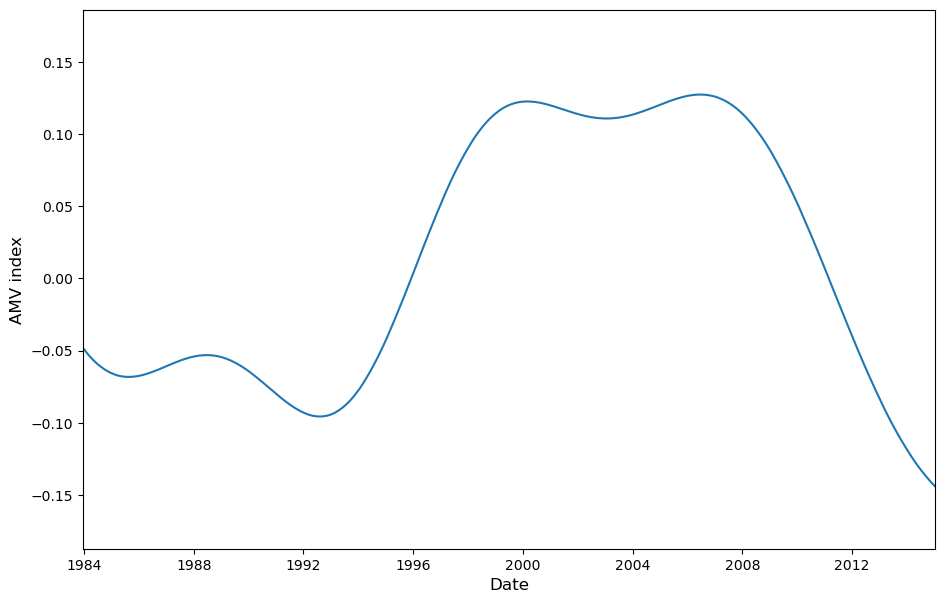

In [6]:
fig,ax = plt.subplots(figsize=(11,7))
ax.plot(sst.time,AMV_index)
#plt.plot(nino34.sel(time=nino_date).time,nino34.sel(time=nino_date),'o',markersize=5)
#plt.plot(nino34.sel(time=nina_date).time,nino34.sel(time=nina_date),'o',markersize=5)
plt.xlim(sst.isel(time=59).time, sst.isel(time=len(AMV_index)-60).time)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AMV index', fontsize=12)

In [7]:
AMV_index = xr.DataArray(AMV_index, coords = [sst.time], dims=['time'])

In [8]:
# Save the outputs
dataset_name = "ERA5_1x1"

AMV_index.to_netcdf("./AMVindex_" + dataset_name + ".nc") #netCDF format
"/work/users/gcerato/ICTP/"

'/work/users/gcerato/ICTP/'